In [1]:
import os

from pathlib import Path
import torch
import torch.nn as nn
from config import get_config, get_weights_file_path
from train import get_model, get_ds, run_validation

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
def loss_se(predicted: torch.Tensor, gt: torch.Tensor):
    """
    Calculate the squared error between two tensors.

    Args:
        tensor1 (torch.Tensor): The first tensor.
        tensor2 (torch.Tensor): The second tensor.

    Returns:
        torch.Tensor: The squared error between tensor1 and tensor2.
    """
    if predicted.shape != gt.shape:
        raise ValueError("Tensors must have the same shape.")

    squared_diff = (predicted - gt) ** 2

    return squared_diff

def plot_results(cfg: dict, gt: torch.Tensor, pred: torch.Tensor, src_input: torch.Tensor, inds: list):
    history = [i for i in range(0,cfg['src_seq_len'])]
    future = [i for i in range(cfg['src_seq_len'],cfg['src_seq_len']+cfg['val_seq_len'])]

    for gt_tensor, pred_tensor, src in zip(gt[inds], pred[inds], src_input[inds]):
        plt.figure()

        plt.plot(history, src, label="History", color='g')
        if cfg['val_seq_len'] == 1:
            plt.plot(future, gt_tensor, label="Ground Truth", marker='o', color='b')
            plt.plot(future, pred_tensor, label="Predicted", marker='o', color='r')
        else:
            plt.plot(future, gt_tensor, label="Ground Truth", color='b')
            plt.plot(future, pred_tensor, label="Predicted", color='r')

        # Add labels and legend
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()

        # Show the plot
        plt.show()

def compute_metrics(model, cfg, train_dataloader, val_dataloader, label_scaler, device, result_dict):
    for tv, dataloader in zip(["train", "val"], [train_dataloader, val_dataloader]):
        # calculate validation data
        loss, ground_truth, predicted, _ = run_validation(model, cfg, dataloader, label_scaler, device, lambda msg: print(msg), 0, None, 0)
        ground_truth_tensor, predicted_tensor = torch.cat(ground_truth), torch.cat(predicted)
        
        result_dict[f"{tv}_total_loss"].append(loss)

        # get loss for each datapoint
        se_loss_raw = loss_se(predicted_tensor, ground_truth_tensor)
        for ind, error in enumerate(se_loss_raw.mean(dim=0)):
            result_dict[f"{tv}_forecast_{f'0{ind+1}'[-2:]}"].append(error)

        # get score metrics
        result_dict[f"{tv}_metrics"].append({
            "r2": r2_score(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2)),
            "rmse": mean_squared_error(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2), squared=False),
            "mae": mean_absolute_error(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2)),
        })

In [12]:
def create_dict(cfg):
    pred_dict = {
        "train_total_loss": [],
        "val_total_loss": [],
        "train_metrics": [],
        "val_metrics": [],
    }
    for i in range(cfg["val_seq_len"]):
        pred_dict[f"train_forecast_{f'0{i+1}'[-2:]}"] = []
        pred_dict[f"val_forecast_{f'0{i+1}'[-2:]}"] = []

    return pred_dict

def timestep_prediction_loss(cfg):
    pred_dict = create_dict(cfg)
    model_names = [f'0{i}'[-2:] for i in range(100)]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_dataloader, val_dataloader, label_scaler, _ = get_ds(cfg, train_bs = 1024)
    model = get_model(cfg).to(device)

    num_models = len(os.listdir(cfg['model_folder']))
    assert num_models <= len(model_names)

    for k in range(num_models):
        model_filename = get_weights_file_path(cfg, model_names[k])
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
    
        compute_metrics(model, cfg, train_dataloader, val_dataloader, label_scaler, device, pred_dict)

    return pred_dict
        
    

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
cfg = get_config()

Using device: cpu


In [9]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
cfg = get_config()

### MODIFY CONFIG
#cfg['val_seq_len'] = 1
# cfg['tgt_seq_len'] = 1

# cfg['model_folder'] = 'weights'
# cfg['experiment_name'] = 'runs/tmodel'
# cfg['run'] = 0


train_dataloader, val_dataloader, label_scaler, val_dataloader_onebatch = get_ds(cfg, train_bs = 1024)
model = get_model(cfg).to(device)

# Load the pretrained weights
model_filename = get_weights_file_path(cfg, f"10")
state = torch.load(model_filename)
model.load_state_dict(state['model_state_dict'])

if cfg['tgt_seq_len'] < cfg['val_seq_len']:
    raise ValueError("Tensors must have the same shape.")

Using device: cpu


In [ ]:
cfg['val_seq_len'] = 1

In [12]:
for tv, dataloader in zip(["Training Data", "Validation Data"], [train_dataloader, val_dataloader]):
    # calculate validation data
    loss, ground_truth, predicted, src_input = run_validation(model, cfg, dataloader, label_scaler, device, lambda msg: print(msg), 0, None, 0)
    ground_truth_tensor, predicted_tensor, src_input_tensor = torch.cat(ground_truth), torch.cat(predicted), torch.cat(src_input)

    # get loss for each datapoint
    se_loss_raw = loss_se(predicted_tensor, ground_truth_tensor)
    if predicted_tensor.size(1) > 1:
        se_loss_val = se_loss_raw.mean(dim=1).unsqueeze(-1)
    else:
        se_loss_val = se_loss_raw

    print(f'{10*"-"} {tv} {10*"-"}')
    print("Time-step\tError")
    for ind, error in enumerate(se_loss_raw.mean(dim=0)):
        print(f"{ind+1}\t\t{float(error):.2f}")

    # calculate score metrics
    r2 = r2_score(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2))
    rmse = mean_squared_error(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2), squared=False)
    mae = mean_absolute_error(ground_truth_tensor.squeeze(1,2), predicted_tensor.squeeze(1,2))
    print(f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2f}")

# get k random, best and worst predictions
k = 5
max_loss_inds = se_loss_val.squeeze(1,2).topk(k=k,largest=True).indices.tolist()
min_loss_inds = se_loss_val.squeeze(1,2).topk(k=k,largest=False).indices.tolist()
rand_inds = np.random.randint(0, len(ground_truth_tensor), size=k).tolist()

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [02:22<00:00,  3.39s/it]


Validation loss of epoch 0: 24172.220703125
---------- Training Data ----------
Time-step	Error
1		17689.75
2		22871.53
3		23805.81
4		23827.00
5		25266.02
6		26177.41
7		26654.35
8		27085.91
RMSE: 155.1839141845703
MAE: 115.95559692382812
R2: 0.25879892179588215


100%|██████████| 23/23 [00:52<00:00,  2.27s/it]

Validation loss of epoch 0: 25985.111328125
---------- Validation Data ----------
Time-step	Error
1		16901.17
2		23296.16
3		25893.03
4		26729.34
5		28190.36
6		28776.36
7		29046.75
8		29047.74
RMSE: 160.67999267578125
MAE: 116.20594787597656
R2: 0.08333099991539293


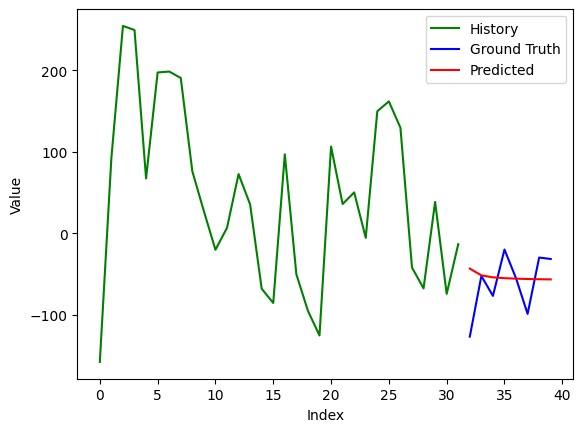

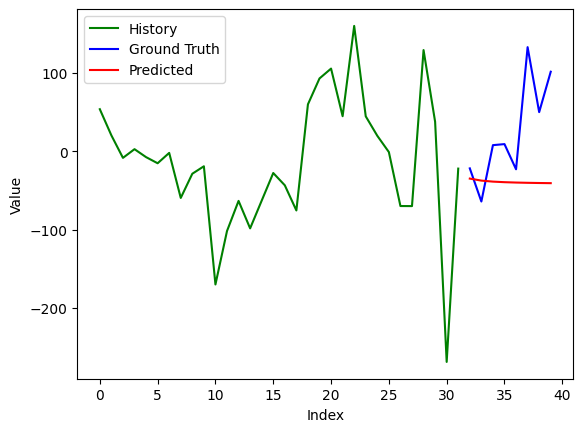

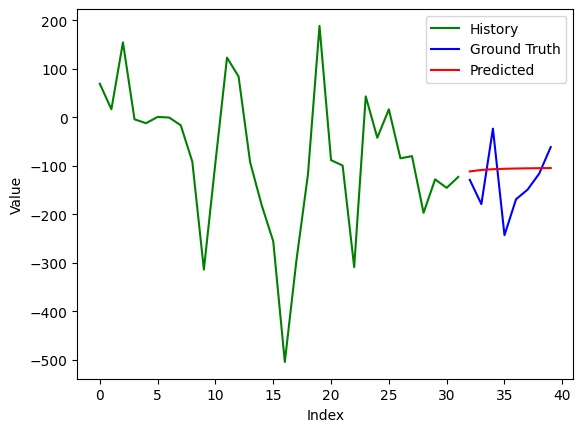

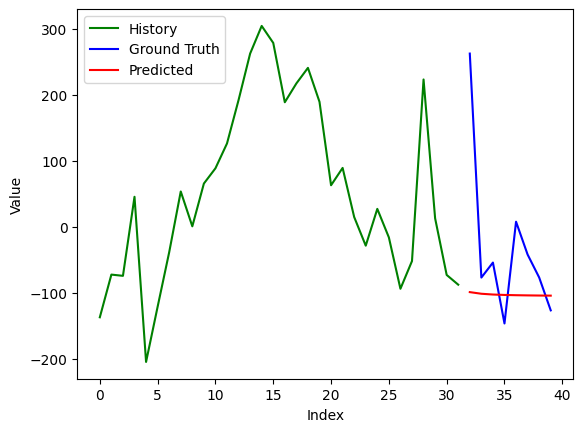

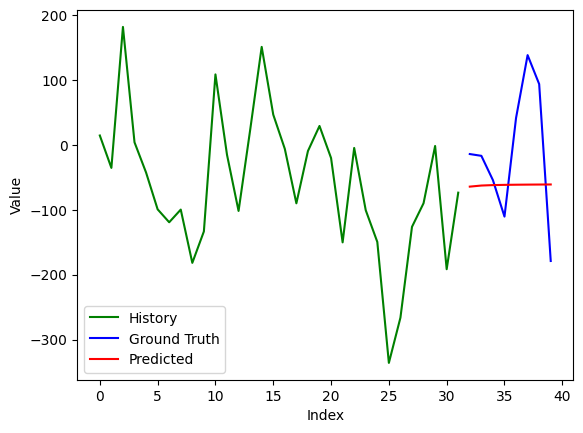

In [13]:
plot_results(cfg, ground_truth_tensor, predicted_tensor, src_input_tensor, inds=rand_inds)

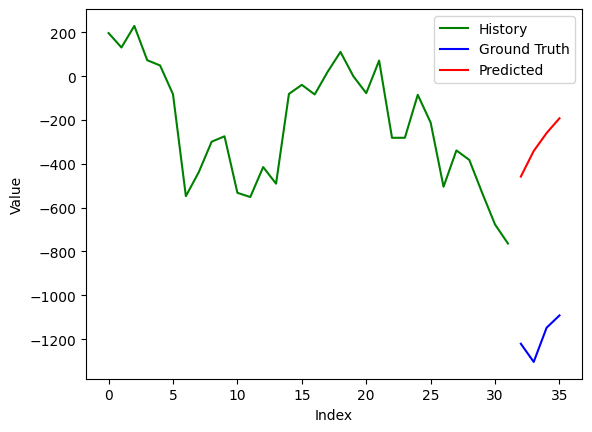

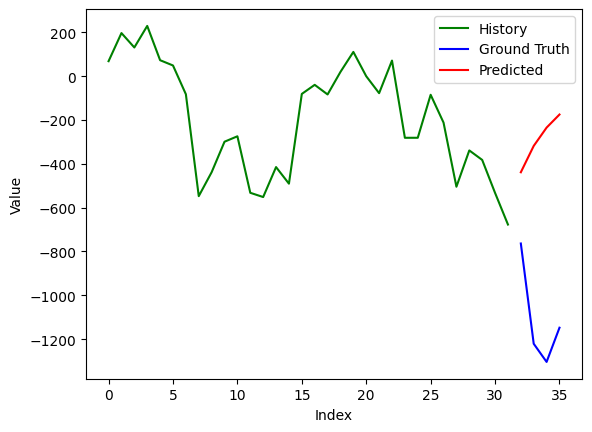

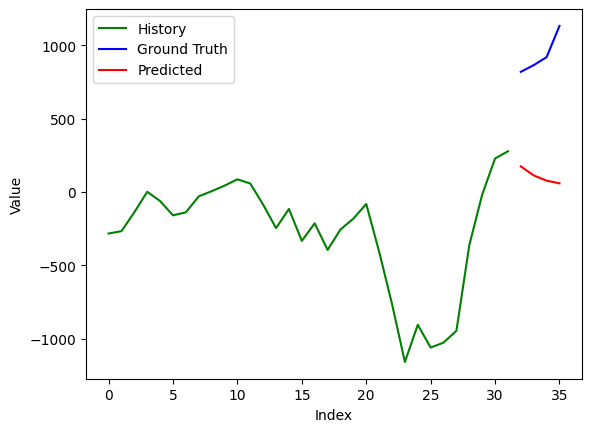

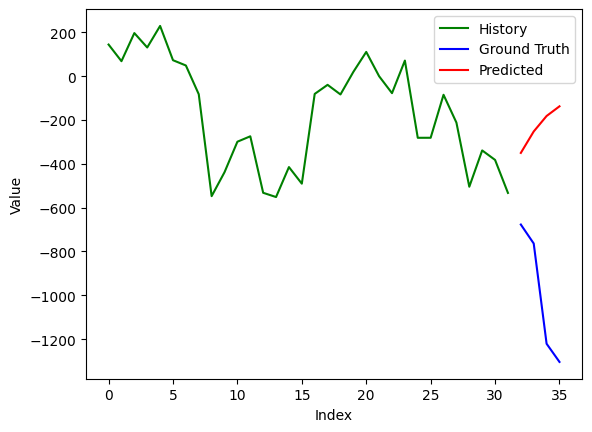

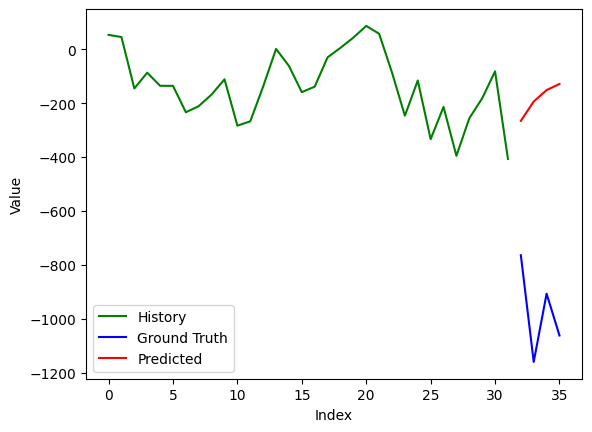

In [26]:
plot_results(cfg, ground_truth_tensor, predicted_tensor, src_input_tensor, inds=max_loss_inds)

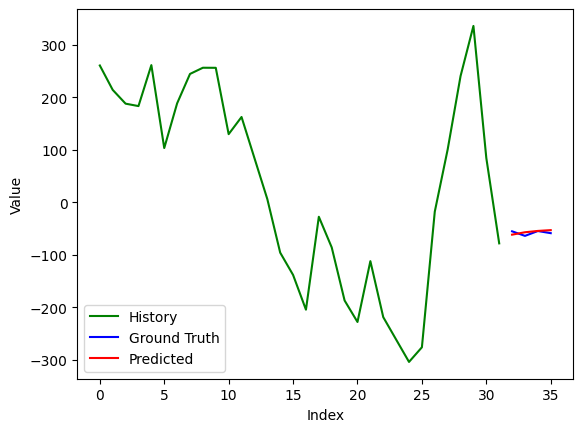

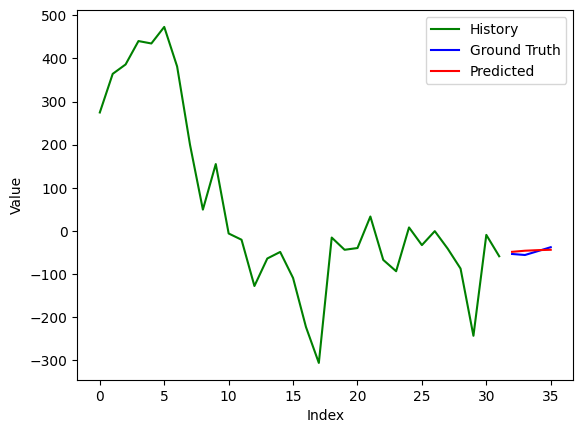

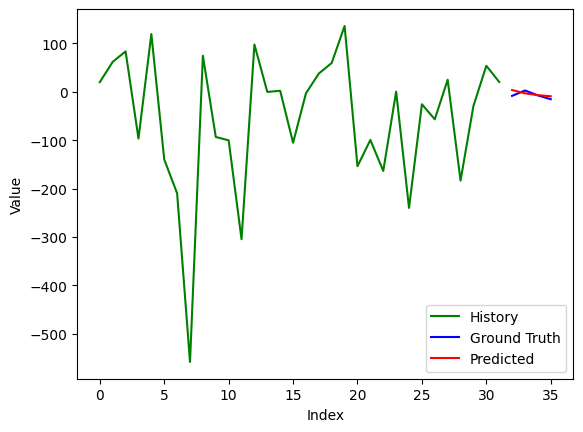

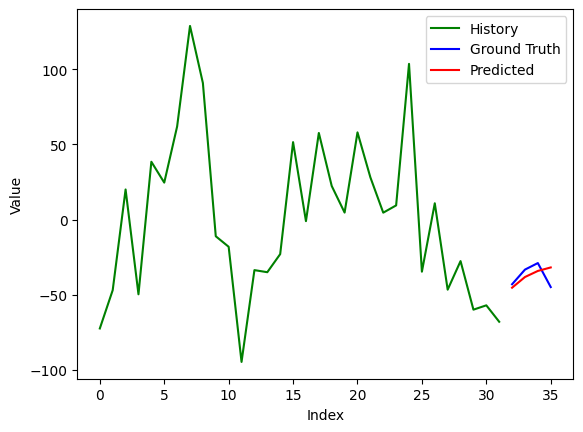

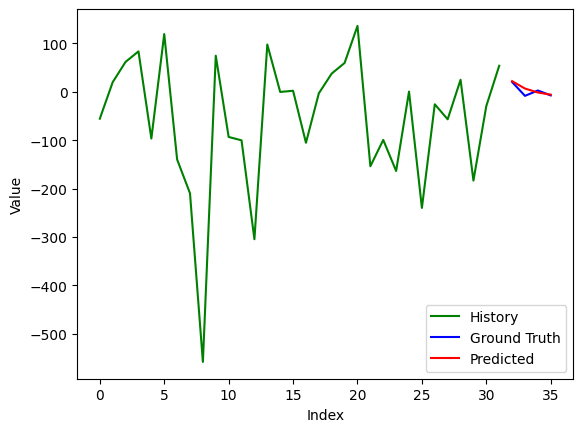

In [27]:
plot_results(cfg, ground_truth_tensor, predicted_tensor, src_input_tensor, inds=min_loss_inds)